# **Taller 3**

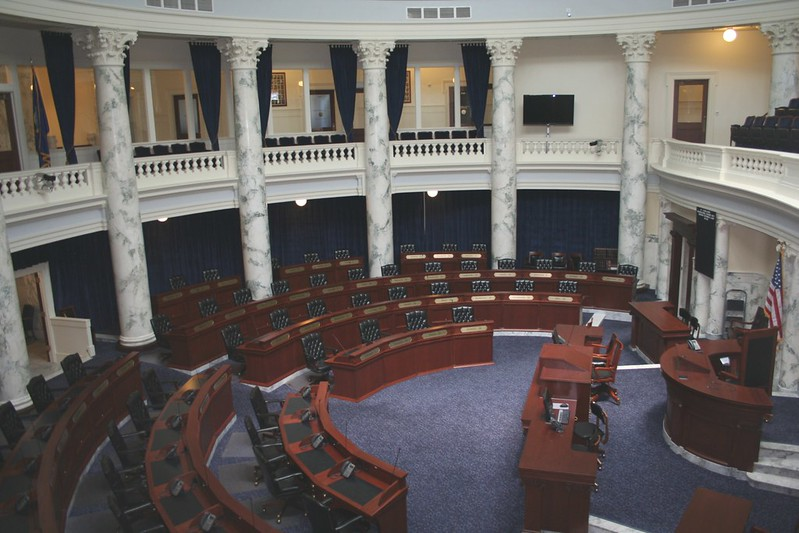

# Links Útiles


[Intuición sobre regresión lineal](https://www.youtube.com/watch?v=nk2CQITm_eo&list=PLblh5JKOoLUIzaEkCLIUxQFjPIlapw8nU&index=2&ab_channel=StatQuestwithJoshStarmer)

[Significancia de la regresión lineal](https://www.statology.org/a-simple-guide-to-understanding-the-f-test-of-overall-significance-in-regression/#:~:text=The%20F,has%20the%20following%20two%20hypotheses)

[Supuestos regresión lineal simple](https://online.stat.psu.edu/stat500/lesson/9/9.2/9.2.3)

[Supuestos de regresión lineal extra I](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)


[Supuestos de regresión lineal extra II](https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression)

# Introducción


Como equipo se encuentran en el grupo de asesores para el ministerio de la mujer y equidad de género de un gobierno ficticio sobre una población ficticia. Se les da la tarea de, a partir de un dataset, analizar la realidad país respecto a la remuneración laboral, el nivel de educación y la igualdad de género.

# Datos & Libs

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t
from scipy.stats import f as fisher
from sklearn.linear_model import LinearRegression

In [ ]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQ3p-2Nck8Y0ALjngIdquzJjF_ryIvU3brk18owc2WidOODHaAPL5revcfceeZ6bgIi-rjtPKjIsW9i/pub?gid=1189476887&single=true&output=csv")
df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0
...,...,...,...,...,...,...
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0


# Funciones

### Intervalos de confianza

In [ ]:
def IC_media(n, media_muestral, std_muestral, alpha=0.05):
    return t.interval(1-alpha, df=n-1, loc=media_muestral, scale=std_muestral/np.sqrt(n))

def IC_prop(n1,frac1,alpha=0.05):
  std_err = np.sqrt((frac1*(1.0-frac1)/n1))
  z_alpha = norm.ppf(1-alpha/2.0)
  IC_inf = frac1 - z_alpha * std_err
  IC_sup = frac1 + z_alpha * std_err
  return (IC_inf,IC_sup)

#para media1-media2
def IC_dos_medias_hetero(muestra1, muestra2, alpha=0.05):
  n1 = len(muestra1); n2 = len(muestra2);
  media1 = np.mean(muestra1); media2 = np.mean(muestra2);
  std1 = np.std(muestra1,ddof=1); std2 = np.std(muestra2,ddof=1);
  gl_num = (std1**2/float(n1) + std2**2/float(n2))**2
  gl_den = ((std1**2/float(n1))**2)/(n1-1.0) + ((std2**2/float(n2))**2)/(n2-1.0)
  gl = int(np.floor(gl_num/gl_den))
  t_alpha = t.ppf(1-alpha/2.0,df=gl)
  std_error = np.sqrt(std1**2/n1 + std2**2/n2)
  IC_inf = (media1-media2) - t_alpha * std_error
  IC_sup = (media1-media2) + t_alpha * std_error
  return IC_inf,IC_sup

#para prop1-prop2
def IC_dos_props(n1,n2,frac1,frac2, alpha=0.05):
  std_err = np.sqrt((frac1*(1.0-frac1)/n1) + (frac2*(1.0-frac2)/n2))
  z_alpha = norm.ppf(1-alpha/2.0)
  IC_inf = (frac1-frac2) - z_alpha * std_err
  IC_sup = (frac1-frac2) + z_alpha * std_err
  return IC_inf,IC_sup

### Test de Hipotesis

In [ ]:
#H0: mu1 = mu0 (mu1 desconocida, m0 valor fijo, sigma desconocida)
def contraste_1media(n1,media1,std1,mu0,error_tipo1,alternativa='1>0'):
  region_critica = []
  gl = n1-1
  std_error = np.sqrt(std1**2/n1)
  T0 = (media1-mu0)/std_error#estadistico bajo H0
  if (alternativa=='1>0'):
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1,df=gl), right=np.inf,closed='neither'))
    p_value = 1-t.cdf(T0,df=gl)
  elif (alternativa=='1<0'):
    region_critica.append(pd.Interval(left=-np.inf, right=t.ppf(error_tipo1,df=gl),closed='neither'))
    p_value = t.cdf(T0,df=gl)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=t.ppf(error_tipo1/2,df=gl),closed='neither'))
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1/2,df=gl),right=np.inf,closed='neither'))
    p_value = 2*min(1-t.cdf(T0,df=gl),t.cdf(T0,df=gl))
  return T0, region_critica, p_value


#H0: mu_x = mu_y (mu_x,mu_y ambas no conocidas, sigma diferente y desconocido)
def contraste_2medias(n_x,n_y,media_x,media_y,std_x,std_y,error_tipo1,alternativa='x>y'):
  region_critica = []
  gl_num = (std_x**2/float(n_x) + std_y**2/float(n_y))**2
  gl_den = ((std_x**2/float(n_x))**2)/(n_x-1.0) + ((std_y**2/float(n_y))**2)/(n_y-1.0)
  gl = int(np.floor(gl_num/gl_den))
  std_error = np.sqrt(std_x**2/n_x + std_y**2/n_y)
  T0 = (media_x-media_y)/std_error#estadistico bajo H0
  if (alternativa=='x>y'):
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1,df=gl), right=np.inf,closed='neither'))
    p_value = 1-t.cdf(T0,df=gl)
  elif (alternativa=='x<y'):
    region_critica.append(pd.Interval(left=-np.inf, right=t.ppf(error_tipo1,df=gl),closed='neither'))
    p_value = t.cdf(T0,df=gl)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=t.ppf(error_tipo1/2,df=gl),closed='neither'))
    region_critica.append(pd.Interval(left=t.ppf(1-error_tipo1/2,df=gl),right=np.inf,closed='neither'))
    p_value = 2*min(1-t.cdf(T0,df=gl),t.cdf(T0,df=gl))
  return T0, region_critica, p_value

#H0: sigma1 = sigma2 (sigma1,sigma2 ambas no conocidas)
def contraste_dos_varianzas(n_x,n_y,std_x,std_y,error_tipo1,alternativa='x>y'):
  region_critica = []
  F0 = std_x**2/std_y**2
  if (alternativa=='x>y'):
    region_critica.append(pd.Interval(left=fisher.ppf(1-error_tipo1,dfn=n_x-1, dfd=n_y-1), right=np.inf,closed='neither'))
    p_value = 1-fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1)
  elif (alternativa=='x<y'):
    region_critica.append(pd.Interval(left=-np.inf, right=fisher.ppf(error_tipo1,dfn=n_x-1, dfd=n_y-1),closed='neither'))
    p_value = fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=fisher.ppf(error_tipo1/2,dfn=n_x-1, dfd=n_y-1),closed='neither'))
    region_critica.append(pd.Interval(left=fisher.ppf(1-error_tipo1/2,dfn=n_x-1, dfd=n_y-1),right=np.inf,closed='neither'))
    p_value = 2*min(1-fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1),fisher.cdf(F0,dfn=n_x-1, dfd=n_y-1))
  return F0, region_critica, p_value

#H0: p1 = p0 (p1 desconocida, p0 valor fijo)
def contraste_1prop(n1,prop1,p0,error_tipo1,alternativa='1>0'):
  region_critica = []
  std_error = np.sqrt(p0*(1.0-p0))*np.sqrt(1.0/n1)
  Z0 = (prop1-p0)/std_error
  if (alternativa=='1>0'):
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1), right=np.inf,closed='neither'))
    p_value = 1-norm.cdf(Z0)
  elif (alternativa=='1<0'):
    region_critica.append(pd.Interval(left=-np.inf, right=norm.ppf(error_tipo1),closed='neither'))
    p_value = norm.cdf(Z0)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=norm.ppf(error_tipo1/2),closed='neither'))
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1/2),right=np.inf,closed='neither'))
    print(">>",Z0,1-norm.cdf(Z0),norm.cdf(Z0))
    p_value = 2*min(1-norm.cdf(Z0),norm.cdf(Z0))
  return Z0, region_critica, p_value

#H0: p1 = p2 (p1,p2 no conocidas, ni funcion una de la otra)
def contraste_2props(n_x,n_y,prop_x,prop_y,error_tipo1,alternativa='x>y'):
  region_critica = []
  prop_comb = (n_x*prop_x + n_y*prop_y)/(n_x+n_y)
  std_error = np.sqrt(prop_comb*(1.0-prop_comb))*np.sqrt(1.0/n_x + 1.0/n_y)
  Z0 = (prop_x-prop_y)/std_error

  if (alternativa=='x>y'):
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1), right=np.inf,closed='neither'))
    p_value = 1-norm.cdf(Z0)
  elif (alternativa=='x<y'):
    region_critica.append(pd.Interval(left=-np.inf, right=norm.ppf(error_tipo1),closed='neither'))
    p_value = norm.cdf(Z0)
  else:#dos colas
    region_critica.append(pd.Interval(left=-np.inf,right=norm.ppf(error_tipo1/2),closed='neither'))
    region_critica.append(pd.Interval(left=norm.ppf(1-error_tipo1/2),right=np.inf,closed='neither'))
    print(">>",Z0,1-norm.cdf(Z0),norm.cdf(Z0))
    p_value = 2*min(1-norm.cdf(Z0),norm.cdf(Z0))
  return Z0, region_critica, p_value

### Regresión lineal

In [ ]:
def p_value_analysis(X, y, reg, alpha):

    y_pred = reg.predict(X)
    SS_fit = np.sum((y - y_pred) ** 2)

    y_mean = np.mean(y)
    SS_y_mean = np.sum((y_mean - y) ** 2)

    # grados de libertad, en este caso: cantidad de weights + bias (edad y bias) - cantidad de variables a predecir (salario)
    # bias y salario se cancelan, por lo cual solo quedan features. En este caso |features| = 1
    p = X.shape[1]
    n = len(y)
    # denominador - p - 1 dado que se define p como cantidad de features, falta el bias que se usa como predictor.
    # notar, esto no significa bias = 1, simplemente es la cantidad de variables a utilizar para predecir, bias es una más.
    F_statistic = ((SS_y_mean - SS_fit) / p) / (SS_fit / (n - p - 1))

    p_value = 1 - fisher.cdf(F_statistic, p, n - p - 1)

    print("F-statistic:", F_statistic)
    print("p-value:", p_value)

    if(p_value < alpha):
        # Se busca rechazar
        return True
    return False


# Preguntas

#### 1. Su primera responsabilidad es asegurarse de la integridad de los datos a trabajar. ¿Cómo abordaría este proceso de forma eficiente?

In [ ]:
df.shape

(6704, 6)

In [ ]:
df.dropna().shape

(6698, 6)

Al observar que cuando simplemente no se consideran las filas con valores nulos la cantidad de datos disminuye marginalmente, deciden tomar dicho camino en vez de profundizar en técnicas más avanzadas, como podría ser el reemplazo de datos.

In [ ]:
df.dropna(inplace=True)

#### 2. Explore los datos. ¿Qué columnas parecen más relevantes? ¿Qué ideas de exploración creen relevantes como grupo?

In [ ]:
df.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')

In [ ]:
df.describe()

,Age,Years of Experience,Salary
count,6698.000000,6698.000000,6698.000000
mean,33.623022,8.095178,115329.253061
std,7.615784,6.060291,52789.792507
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


Notan que la media del salario es de 115329 dólares, mientras que la mediana es de 115000, por lo cual los datos están sesgados a una parte de la población con mayores ingresos ¿Que ideas de exploración creen relevantes como grupo?

In [ ]:
df["Education Level"].unique()

array(["Bachelor's", "Master's", 'PhD', "Bachelor's Degree",
       "Master's Degree", 'High School', 'phD'], dtype=object)

Notan que los mismos niveles educacionales tienen distintos nombres, entonces proceden a estandarizar con su conocimiento sobre funciones lambda y el muy importante metodo apply:

In [ ]:
df['Education Level'] = df['Education Level'].apply(lambda x: "Bachelor's Degree" if "bachelor" in x.lower()
                                                    else "Master's Degree" if "master" in x.lower()
                                                    else "PhD" if "phd" in x.lower() or "ph.d" in x.lower()
                                                    else x)

print(df['Education Level'].unique())

["Bachelor's Degree" "Master's Degree" 'PhD' 'High School']


In [ ]:
df["Job Title"].unique()

array(['Software Engineer', 'Data Analyst', 'Senior Manager',
       'Sales Associate', 'Director', 'Marketing Analyst',
       'Product Manager', 'Sales Manager', 'Marketing Coordinator',
       'Senior Scientist', 'Software Developer', 'HR Manager',
       'Financial Analyst', 'Project Manager', 'Customer Service Rep',
       'Operations Manager', 'Marketing Manager', 'Senior Engineer',
       'Data Entry Clerk', 'Sales Director', 'Business Analyst',
       'VP of Operations', 'IT Support', 'Recruiter', 'Financial Manager',
       'Social Media Specialist', 'Software Manager', 'Junior Developer',
       'Senior Consultant', 'Product Designer', 'CEO', 'Accountant',
       'Data Scientist', 'Marketing Specialist', 'Technical Writer',
       'HR Generalist', 'Project Engineer', 'Customer Success Rep',
       'Sales Executive', 'UX Designer', 'Operations Director',
       'Network Engineer', 'Administrative Assistant',
       'Strategy Consultant', 'Copywriter', 'Account Manager',
      

Parecen haber múltiples trabajos, muchos de los cuales podrían referir al mismo cargo. Como grupo consideran utilizar un LLM para clasificar posibles nombres de trabajo que refieran al mismo rol.


A partir de su juicio del análisis provisto de un LLM se deciden realizar los siguientes cambios:

In [ ]:
df["Job Title"].unique().size

191

In [ ]:
replacements = {
    'Director of Marketing': 'Marketing Director',
    'Customer Service Rep': 'Customer Service Representative',
    'Human Resources Manager': 'HR Manager',
    'Front end Developer': 'Front-End Developer',
    'Front End Developer': 'Front-End Developer',
    'Human Resources Coordinator': 'HR Coordinator',
    'Juniour HR Coordinator': 'Junior HR Coordinator',
    'Junior HR Coordinator': 'Junior HR Coordinator',
    'Director of Sales': 'Sales Director'
}

df['Job Title'] = df['Job Title'].replace(replacements)

df['Job Title'].unique().size

185

Ahora deciden continuar con el análisis estadístico pertinente.

#### 3. ¿Cuál es el intervalo de confianza del 95% para el salario promedio de las personas que cuyo nivel máximo de educación es un Bachelors degree? ¿Se puede decir que supera los 100_000 dólares?

Primero se explicitan los supuestos, esta parte es importante para justificar el  tipo de intervalo de confianza a construir:

**Supuestos:**

*   Como el dataset corresponde a una **muestra**, entonces no se conoce la varianza poblacional de los salarios. Además, no se entrega ningún tipo de información sobre esta, por lo tanto se considerará que la varianza es desconocida.
*   Los salarios siguen una distribución normal. Otra opción es decir que debido al **Teorema del Límite Central**, la distribución de los salarios converge a una distribución Normal cuando la cantidad de datos ($n$) es muy grande.
* Las muestras son IID.

Por lo tanto, se debe construir un **IC para la media con varianza desconocida**, el cual corresponde a la función ``IC_media`` proporcionada en la sección de funciones.

In [ ]:
df_Bachelors = df.loc[df["Education Level"] == "Bachelor's Degree"]

#Se construye el IC
intervalo = IC_media(n = df_Bachelors.shape[0],
                     media_muestral = df_Bachelors["Salary"].mean(),
                     std_muestral = df_Bachelors["Salary"].std(),
                     alpha = 0.05)

intervalo

(93509.99618319301, 96655.82109585365)

**Conclusión:**
Dado que \$100.000 no está dentro del intervalo de confianza, entonces se puede concluir con un 95% de confianza que $100.000 **no** es una estimación plausible del salario promedio verdadero (poblacional) de las personas cuyo nivel máximo de educación es un Bachelor's Degree.

#### 4. Determine utilizando IC si el salario promedio de las personas cuyo nivel mínimo de educación es Master's Degree es mayor al salario promedio de las personas con nivel máximo **logrado** de educación de Bachelor's Degree. Considere un 90% de confianza en su respuesta.

**Supuestos:**


* Las varianzas de los salarios en los dos grupos son desconocidas. Además, no existe información que nos indique que estas sean iguales (Homoscedasticidad), por lo tanto se considerará que las varianzas son desconocidas y distintas (Heteroscedasticidad)

* Los salarios siguen una distribución normal. Otra opción es decir que debido al **Teorema del Límite Central**, la distribución de los salarios converge a una distribución Normal cuando la cantidad de datos ($n$) es muy grande.

* Las muestras son IID.



Por lo tanto, se debe construir un **IC para la Diferencia de Medias bajo Heteroscedasticidad**, el cual corresponde a la función ``IC_dos_medias_hetero`` proporcionada en la sección funciones.

In [ ]:
#Se filtran los datos
df_max_bachelor = df.loc[df["Education Level"] == "Bachelor's Degree"]
df_min_master = df.loc[(df["Education Level"] == "Master's Degree") | (df["Education Level"] == "Phd")]

#Se construye el IC
intervalo_diff = IC_dos_medias_hetero(muestra1 = df_min_master["Salary"],
                                      muestra2 = df_max_bachelor["Salary"],
                                      alpha = 0.1)

print(intervalo_diff)

(32993.11312614252, 37065.18249803664)


**Conclusión:** Dado que el intervalo es completamente positivo se puede afirmar, con un 90% de confianza, que las personas con un nivel mínimo de educación de Master's Degree tienen sueldos mayores que las personas cuyo nivel máximo logrado de educación es Bachelor's Degree.

#### 5. Con una significancia del 5% ¿Se puede afirmar que los hombres con un nivel mínimo logrado de educación de Master's Degree reciben, en promedio, un mayor sueldo que las mujeres con el mismo nivel de educación?

**Supuestos:**

* Las varianzas de los salarios en los dos grupos/poblaciones son desconocidas. Además, no existe información que nos indique que estas sean iguales (Homoscedasticidad), por lo tanto se considerará que las varianzas son desconocidas y distintas (Heteroscedasticidad)
* Los salarios siguen una distribución normal. Otra opción es decir que debido al **Teorema del Límite Central**, la distribución de los precios converge a una distribución Normal cuando la cantidad de datos ($n$) es muy grande.
* Las muestras son IID.

Por lo tanto, se debe realizar un **Test para comparar dos medias con varianzas desconocidas**, el cual corresponde a la función ``contraste_2medias`` proporcionada en la sección de funciones

---

Sea:
* $\mu_M$: Salario promedio de mujeres con nivel de educación mínimo logrado de Master's Degree.
* $\mu_H$: Salario promedio de hombres con nivel de educación mínimo logrado de Master's Degree.

Entonces, el test de hipótesis que se pide es:

$$
H_0: \mu_M = \mu_H\\
H_1: \mu_M < \mu_H
$$

Otra opción válida es el test:
$$
H_0: \mu_M \geq \mu_H\\
H_1: \mu_M < \mu_H
$$


In [ ]:
#Se filtran los datos
df_hombres_master = df.loc[((df["Education Level"] == "Master's Degree") | (df["Education Level"] == "Phd")) & (df["Gender"] == "Male")]
df_mujeres_master = df.loc[((df["Education Level"] == "Master's Degree") | (df["Education Level"] == "Phd")) & (df["Gender"] == "Female")]

#x son las mujeres, y son los hombres
test_H_M = contraste_2medias(n_x = df_mujeres_master.shape[0],
                         n_y = df_hombres_master.shape[0],
                         media_x = df_mujeres_master["Salary"].mean(),
                         media_y = df_hombres_master["Salary"].mean(),
                         std_x = df_mujeres_master["Salary"].std(),
                         std_y = df_hombres_master["Salary"].std(),
                         error_tipo1 = 0.05,
                         alternativa = "x<y")

estadistico, region_critica, p_valor = test_H_M
print(f"El estadístico T0 es {estadistico}")
print(f"La region crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

El estadístico T0 es -9.480834718518787
La region crítica es (-inf, -1.6457024912116602)
El p-valor es 3.837832432166684e-21


**Conclusión:**

* Dado que el estadístico de contraste $T_0$ está dentro de la región crítica, entonces se rechaza $H_0$, es decir, la evidencia señala que es estadísticamente muy improbable que sea cierta.
* Como se rechazó $H_0$, entonces existe evidencia estadística para respaldar la afirmación.
* El **p-valor** se puede considerar como "el mínimo valor de $\alpha$ para el cual se rechaza $H_0$". Por lo tanto, un p-valor de $3.83\cdot10^{-21}$ nos indica que podemos rechazar $H_0$ con nivel de confianza muy cercano al $100\%$, es decir, existe una fuerte evidencia en contra de la hipótesis nula.
* Para $\alpha > \text{p-valor}$, se rechaza $H_0$.
* Para $\alpha < \text{p-valor}$, no se rechaza $H_0$.

#### 6. Con una significancia del 10% ¿Se puede afirmar que hay una mayor proporción de mujeres que completaron algún nivel de educación superior que de hombres?

**Supuestos:**

* Debido al **Teorema del Límite Central**, las distribuciones de las proporciones convergen a una distribución Normal cuando la cantidad de datos ($n$) es muy grande.
* Las muestras son IID.

---

Sea:
* $p_M$: Proporción de mujeres que completaron educación superior.
* $p_H$: Proporción de hombres que completaron educación superior.

Entonces, el test de hipótesis que se pide es:
$$
H_0: p_M = p_H\\
H_1: p_H< p_M
$$


In [ ]:
df_mujeres_ed_superior = df.loc[(df["Education Level"].isin(["Master's Degree", "Phd", "Bachelor's Degree"])) & (df["Gender"] == "Female")]
df_hombres_ed_superior = df.loc[(df["Education Level"].isin(["Master's Degree", "Phd", "Bachelor's Degree"])) & (df["Gender"] == "Male")]


n_mujeres = df[df.Gender == "Female"].shape[0]
n_mujeres_ed_superior = df_mujeres_ed_superior.shape[0]
p_mujeres_ed_superior = n_mujeres_ed_superior / n_mujeres

n_hombres = df[df.Gender == "Male"].shape[0]
n_hombres_ed_superior = df_hombres_ed_superior.shape[0]
p_hombres_ed_superior = n_hombres_ed_superior / n_hombres

#x es hombres, y es mujeres
test_engineer = contraste_2props(n_x = n_hombres,
                                 prop_x= p_hombres_ed_superior,
                                 n_y = n_mujeres,
                                 prop_y = p_mujeres_ed_superior,
                                 error_tipo1 = 0.1,
                                 alternativa = "x<y")

estadistico, region_critica, p_valor = test_engineer

print(f"El estadístico Z0 es {estadistico}")
print(f"La región crítica es {region_critica[0]}")
print(f"El p-valor es {p_valor}")

El estadístico Z0 es -3.6905129262245238
La región crítica es (-inf, -1.6448536269514729)
El p-valor es 0.00011190115758303122


**Conclusión:**

* Dado que el estadístico de contraste $Z_0$ está dentro de la región crítica, entonces se rechaza $H_0$, es decir, la evidencia señala que es estadísticamente muy improbable que sea cierta.
* Como se rechazó $H_0$, entonces existe evidencia estadística para respaldar la afirmación.

#### 7. Realice una regresión lineal simple, **justificando su validez**, donde se utilicen los años de experiencia del trabajo para estimar el salario de las personas.

In [ ]:
# Notar que también existe la regresión lineal múltiple, la función utilizada está optimizada para ese tipo de regresión,
# por esto se aplica el método reshape ¿Saben que es lo que hace reshape?
X = df["Years of Experience"].to_numpy().reshape(-1,1)
y = df["Salary"].to_numpy()

reg = LinearRegression()
reg.fit(X, y)
reg.score(X, y)

0.6544294992867405

Notar que podría ser una buena idea realizar el fit del modelo con un training set y luego evaluar con score sobre un testing set.

Al utilizar el método score, el número que se retorna corresponde a $R^2$.

Para evaluar la validez de nuestro modelo de regresión lineal simple primero se abordaran los siguientes supuestos:

1. Linealidad entre predictores y resultados.
2. Normalidad de los residuos.
3. Independencia de los residuos.
4. Homoscedasticidad.


Linealidad

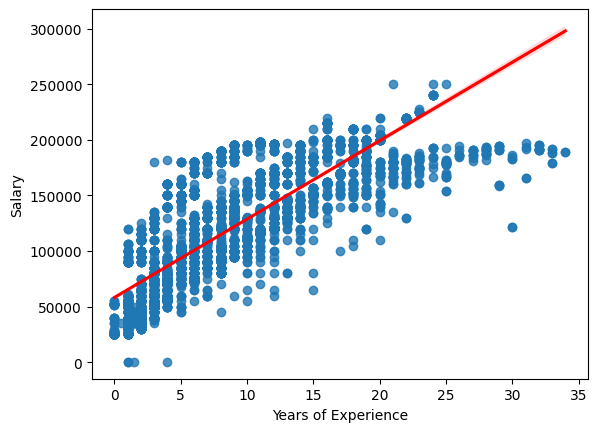

In [ ]:
sns.regplot(x='Years of Experience', y='Salary', data=df, line_kws={"color": "red"})
plt.show()

Se observa una tendencia a una correlación positiva entre los datos.

Normalidad de los residuos

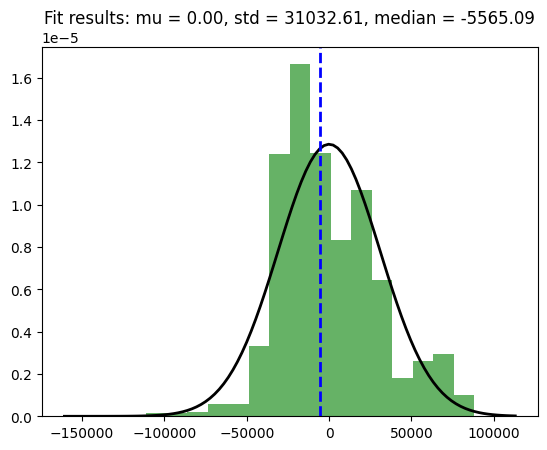

In [ ]:
df['Predicted'] = reg.predict(X)

df['Residuals'] = df['Salary'] - df['Predicted']

plt.hist(df['Residuals'], bins=20, density=True, alpha=0.6, color='g')

mu = df["Residuals"].mean()
std = df["Residuals"].std()
med = df['Residuals'].median()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.axvline(med, color='blue', linestyle='dashed', linewidth=2)

title = f"Fit results: mu = {mu:.2f}, std = {std:.2f}, median = {med:.2f}"
plt.title(title)

plt.show()

Se observa que aunque no perfectamente normal, la distribución de los residuos no es lejana a lo que se busca. La terminología a emplear es que nuestra data se asemeja a un right-skewed normal distribution. ¿Qué se podría concluir respecto a la moda, mediana y media en un una distribución normal right-skewed?

Independencia de los residuos y Heteroscedasticidad

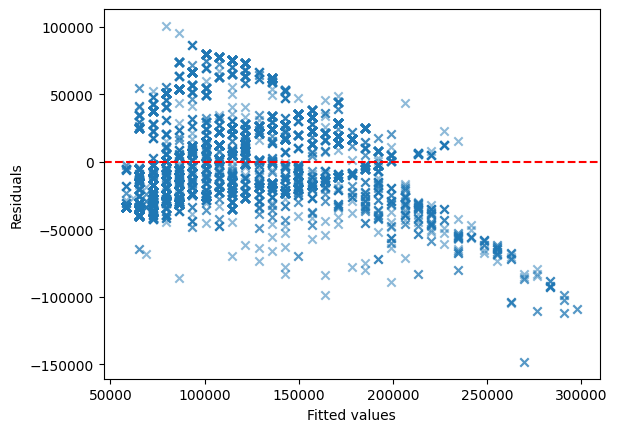

In [ ]:
plt.scatter(df['Predicted'], df['Residuals'], marker = "x", alpha = 0.5)

plt.axhline(y=0, color='r',
            linestyle='--')

plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Primero sintetizamos lo que se busca en cada supuesto para este gráfico:

1. Heteroscedasticidad
La dispersión de los datos alrededor del 0 debe ser constante.

2. Independencia entre el valor de los residuos y el valor "y" predicho:
No debe haber una correlación entre ambos valores.


En el gráfico observamos que cuando se predicen valores por sobre los 240000 dolares no se cumplen los requisitos solicitados por los supuestos.

Luego de analizar la validez de los supuestos en la regresión ¿Es valido el modelo? Hay formas más rigurosas de testear cada supuesto, basados, por ejemplo, en contrastes. En este caso se cosniderará testear la validez del valor $R^2$ predicho con el siguiente test de hipotesis:

In [ ]:
print(reg.score(X,y))
print(p_value_analysis(X, y, reg, 0.05))

0.6544294992867405
F-statistic: 12680.653927865425
p-value: 1.1102230246251565e-16
True
